# Homework 6
Josh Cohen

In [1]:
import numpy as np
import sympy as sym
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp, solve_bvp, trapz

## Problem 1
Demonstrate numerically that the optimal solution obtained by the Riccati equation form Homework 5 problem 4 is indeed optimal. Evaluate the directional derivative of $J$ at $(x_{sol}(t), u_{sol}(t))$ in 10 different directions. Make a table of the 10 directions and the corresponding value of the directional derivative.

In [2]:
optSoln = pd.read_csv("optSolnP4.csv", header=0, index_col=0)

In [3]:
x_opt = optSoln.loc["x0":"x1"].to_numpy()
u_opt = np.expand_dims(optSoln.loc["u"].to_numpy(),0)
t_vec = optSoln.loc["t"].to_numpy()

In [4]:
t, A_sym, B_sym, C_sym, D_sym = sym.symbols('t A B C D')
v_gen = A_sym * sym.sin(B_sym*t + C_sym) + D_sym

In [5]:
def get_rand_v():
    randos = np.random.rand(4)
    v_ret = v_gen.subs({A_sym:randos[0], B_sym:randos[1], C_sym:randos[2], D_sym:randos[3]}) 
    return sym.Matrix([v_ret]), randos

In [6]:
Q = sym.Matrix([[2,0],[0,0.01]])
R = sym.Matrix([0.1])
P1 = sym.Matrix([[1,0],[0,0.01]])

x0 = sym.Function('x_0')(t)
x1 = sym.Function('x_1')(t)
z0 = sym.Function('z_0')(t)
z1 = sym.Function('z_1')(t)

x = sym.Matrix([x0, x1])
z = sym.Matrix([z0, z1])

x_fin = sym.MatrixSymbol('x(T)', 2, 1).as_explicit()
z_fin = sym.MatrixSymbol('z(T)', 2, 1).as_explicit()
x_init = sym.Matrix([10,0]) #possibly want this to be zeros
z_init = np.zeros((2,1))

A = sym.Matrix([[0,1],[-1.6,-0.4]])
B = sym.Matrix([0,1]) 

u0 = sym.Function('u_0')(t)
v0 = sym.Function('v_0')(t)
u = sym.Matrix([u0])
v = sym.Matrix([v0])
b = u.T * R

xdot = A * x + B * u

p = sym.Matrix([sym.Function('p_0')(t), sym.Function('p_1')(t)])
p_fin = sym.MatrixSymbol('p_{1}', 2, 1).as_explicit()
pdot = -A.T * p - Q*x

In [7]:
def compute_dd_for_perturb():
    v_pert, randos =  get_rand_v()
    pert_init = np.concatenate((z_init, v_pert.subs(t,0)))
    zdot = A * z + B * v_pert 
    pert = sym.Matrix([z,v])
    zdot_lam = sym.lambdify([t, pert], sym.flatten(sym.Matrix([zdot, v_pert])))
    
    ans = solve_ivp(zdot_lam, (0, 10), pert_init.flatten(), t_eval=t_vec)
    
    zed = ans.y[:2,:]
    v_lam = sym.lambdify(t,v_pert)
    ved = np.expand_dims(v_lam(t_vec).flatten(),0)
    
    J_dd_integrand = np.zeros(zed.shape[1])
    for i in range(zed.shape[1]) :
        J_dd_integrand[i] = np.matmul(np.matmul(x_opt[:,i].T, Q), zed[:,i]) \
                                        + np.matmul(np.matmul(u_opt[:,i].T, R), ved[:,i])
        
    J_dd_term = np.matmul(np.matmul(x_opt[:,-1].T, P1), zed[:,-1])
    
    J_dd_val = trapz(J_dd_integrand, t_vec) + J_dd_term
    
    return J_dd_val, randos

In [8]:
J_dd_ave = 0
num_perturbs = 10
for i in range(num_perturbs):
    J_dd_val, randos = compute_dd_for_perturb()
    print("For A={:.5f}; B={:.5f}; C={:.5f}; D={:.5f};".format(randos[0], randos[1], randos[2], randos[3]))
    print("J_dd = {:.7f}".format(J_dd_val))
    print("")
    J_dd_ave += J_dd_val/num_perturbs
    
print("This yields an avearge value for the directional derivative of J of: \n{:.7f}".format(J_dd_ave))

For A=0.78787; B=0.40367; C=0.52583; D=0.34221;
J_dd = -0.0068363

For A=0.78039; B=0.00787; C=0.30829; D=0.82650;
J_dd = -0.0102889

For A=0.31633; B=0.36641; C=0.56506; D=0.54324;
J_dd = -0.0067897

For A=0.60707; B=0.01867; C=0.55751; D=0.57839;
J_dd = -0.0087001

For A=0.55678; B=0.04196; C=0.45792; D=0.69346;
J_dd = -0.0090747

For A=0.89390; B=0.43371; C=0.42276; D=0.78645;
J_dd = -0.0107607

For A=0.20501; B=0.03725; C=0.61571; D=0.30826;
J_dd = -0.0041738

For A=0.41599; B=0.72144; C=0.07101; D=0.14564;
J_dd = -0.0014059

For A=0.73852; B=0.61264; C=0.68439; D=0.76566;
J_dd = -0.0114148

For A=0.62927; B=0.88871; C=0.83672; D=0.13566;
J_dd = -0.0052745

This yields an avearge value for the directional derivative of J of: 
-0.0074719


# Probelm 2
Compute the control $u(t)$ that minimizes the given cost function subject to the given constraint and desired trajectory

In [73]:
t = sym.symbols('t')
Q = sym.Matrix([[10,0],[0,1 + sym.Rational(1,8) * sym.sin(t)]])
R = sym.Matrix([1])
P1 = sym.Matrix([[100,0],[0,100]])

A = sym.Matrix([[0, 1+sym.Rational(1,2) * sym.sin(t)], [-1 - sym.Rational(1,2) * sym.cos(t), sym.Rational(1,4) * sym.sin(t)]])
B = sym.Matrix([0, 1 + sym.Rational(1,2) * sym.sin(t)])
#lambdify our time varying A and B
A_lam = sym.lambdify([t], A)
B_lam = sym.lambdify([t], B)

In [74]:
x0 = sym.Function('x_0')(t)
x1 = sym.Function('x_1')(t)

x = sym.Matrix([x0, x1])

x_fin = sym.MatrixSymbol('x(T)', 2, 1).as_explicit()
x_init = sym.Matrix([1,1]) 

u0 = sym.Function('u_0')(t)
u = sym.Matrix([u0])

p = sym.Matrix([sym.Function('p_0')(t), sym.Function('p_1')(t)])
p_fin = sym.MatrixSymbol('p_{1}', 2, 1).as_explicit()

In [75]:
x_d = sym.Matrix([0.1*t + 1, -0.2*t  + 1]) 
x_d_fin = x_d.subs(t,10)

In [76]:
P_0 = sym.Function("P_0")(t)
P_1 = sym.Function("P_1")(t)
P_2 = sym.Function("P_2")(t)
P_3 = sym.Function("P_3")(t)
P = sym.Matrix([[P_0, P_1],[P_2,P_3]])

Pdot = -P * A - A.T * P + P * B * R.inv() * B.T * P - Q
P_fin = P1

r0 = sym.Function("r_0")(t)
r1 = sym.Function("r_1")(t)
r = sym.Matrix([r0, r1])

rdot = -A.T * r + Q * x_d + P*B*R.inv()*B.T*r
r_fin = -P1 * x_d_fin

In [77]:
q_Pr = sym.Matrix([P.reshape(4,1), r])
q_Pr_dot = sym.Matrix([Pdot.reshape(4,1), rdot])
q_Pr_fin = sym.Matrix([P_fin.reshape(4,1), r_fin])

q_Pr_dot_lam = sym.lambdify([t, q_Pr], sym.flatten(q_Pr_dot))

In [78]:
#set up boundary condition
ans_Pr = solve_ivp(q_Pr_dot_lam, [10, 0], np.array(q_Pr_fin).flatten(), max_step = 0.1)

In [79]:
P_t = np.flip(ans_Pr.y[:4,:].reshape(2,2,-1),2)
r_t = np.flip(ans_Pr.y[4:,:].reshape(2,1,-1),2)
t_vec = np.flip(ans_Pr.t,-1)

In [80]:
P_t_init = P_t[:,:,0]
r_t_init = r_t[:,:,0]

# p_init = np.matmul(P_t_init, x_init) + r_t_init

In [81]:
q = sym.Matrix([x,p])
qdot = sym.Matrix([A*x + -B*R.inv()*B.T * p, -Q*x - A.T * p + Q * x_d])
q_init = np.concatenate((np.array(x_init),p_init)).flatten()

qdot_lam = sym.lambdify([t, q], sym.flatten(qdot))

In [82]:
ans_x = solve_ivp(qdot_lam, (0,10), q_init, t_eval=t_vec)

In [83]:
x_t = ans_x.y[:2, ].reshape(2,1,-1)

In [84]:
N = ans_x.t.shape[-1]
u = np.zeros(N)
R_num = np.array(R)[0]
for i in range(N):
    u[i] = np.matmul(-1/R_num * B_lam(t_vec[i]).T, (np.matmul(P_t[:,:,i], x_t[:,:,i]) + r_t[:,:,i]))

<IPython.core.display.Javascript object>


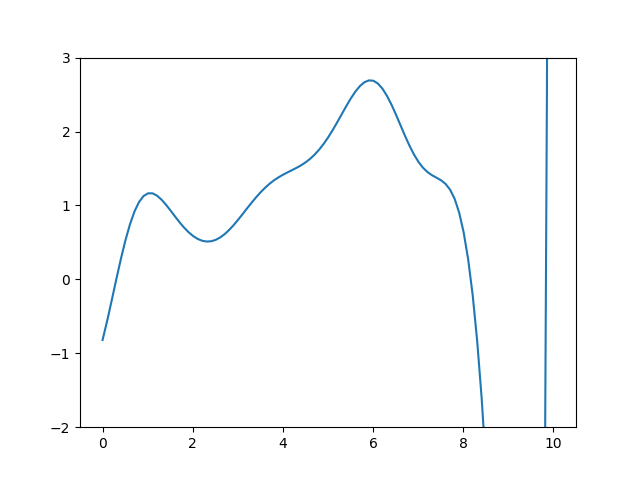

In [85]:
plt.figure()
plt.plot(t_vec, u)
plt.ylim([-2,3])
plt.show()

In [86]:
x_d_traj = sym.lambdify([t], x_d)
x_d_traj = x_d_lam(ans_x.t)
# x_d_traj[:,:,-1]
x_d_traj.shape

(2, 1, 110)

<IPython.core.display.Javascript object>


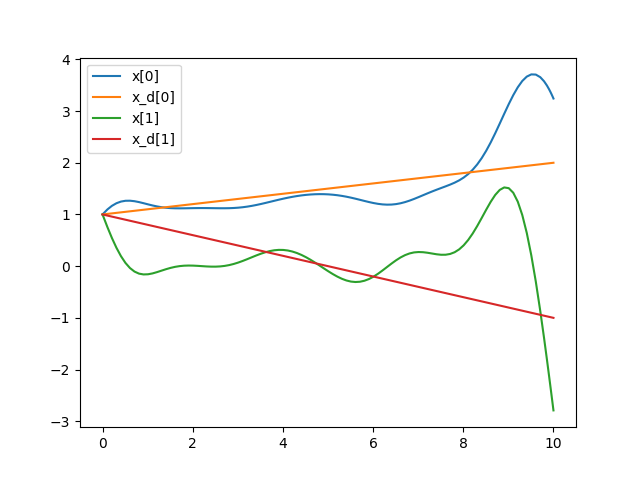

In [89]:
plt.figure()
plt.plot(t_vec, x_t[0,0,:])
plt.plot(t_vec, x_d_traj[0,0,:])
plt.plot(t_vec, x_t[1,0,:])
plt.plot(t_vec, x_d_traj[1,0,:])
plt.legend(["x[0]", "x_d[0]", "x[1]", "x_d[1]"])
plt.show()

In [90]:
# u = (-R.inv() * B.T * (P * x + r))
# xdot = A * x + B * u
# q_xPr = sym.Matrix([P.reshape(4,1), r, x])
# q_xPr_dot = sym.Matrix([Pdot.reshape(4,1), rdot, xdot])
# q_xPr_init = np.concatenate([P_t_init.reshape(4,1), r_t_init, np.array(x_init)]).flatten()

# q_xPr_dot_lam = sym.lambdify([t, q_xPr], sym.flatten(q_xPr_dot))
# q_xPr_dot_lam(0, q_xPr_init)

### Note:
I spent >10 hours trying to get the terminal conditions to line up. I have tried my above implementation as well as a seperate implementation in which i also simultaneously integrate P and r backwards and the integrate P, r, and x forward together I am not sure what I am missing. I tried a sympy version and a pure numpy version, would love a comment if you could see where I went wrong.

## Problem 3
Linearize dynamics of the presented diff drive system to obtain matrix A of costate variable p, use algebra to get u out of TPBVP.

In [19]:
Q = sym.Matrix([[1000,0,0],[0,50,0],[0,0,1]])
R = sym.Matrix([[50, 0], [0, 0.1]])
P1 = sym.Matrix([[10000, 0, 0],[0, 10000,0],[0,0,10]])

t = sym.symbols('t')
u0 = sym.Function('u_0')(t)
u1 = sym.Function('u_1')(t)

u = sym.Matrix([u0, u1])

x = sym.Function('x')(t)
y = sym.Function('y')(t)
theta = sym.Function('theta')(t)

q = sym.Matrix([x, y, theta])

xdot = sym.cos(theta) * u0
ydot = sym.sin(theta) * u0
thetadot = u1

qdot = sym.Matrix([xdot, ydot, thetadot])
q_init = np.array([0,0,np.pi/4])

In [20]:
tspan = np.linspace(0,1,100)
x_d = 4 / (2 * sym.pi) * t
y_d = 0
theta_d = sym.pi/2
q_d = sym.Matrix([x_d, y_d, theta_d])
y_d_traj = np.zeros(tspan.shape[0])
x_d_traj = sym.lambdify([t], 2 * t / sym.pi)(tspan)
q_d_fin = np.array(sym.Matrix([x_d_traj[-1], 0, np.pi/2])).flatten()
q_d_fin

array([0.636619772367581, 0, 1.57079632679490], dtype=object)

In [21]:
#linearize dynamic to obtain A matrix
p = sym.Matrix([sym.Function('p_0')(t), sym.Function('p_1')(t), sym.Function('p_2')(t)])
p_fin = sym.MatrixSymbol('p_{1}', 3, 1).as_explicit()

# p1 = P1.T * x(T)
p1 = np.matmul(P1.T, q_d_fin).flatten()
p1.shape

(3,)

In [22]:
A = qdot.jacobian(q)
B = qdot.jacobian(u)

In [23]:
xdot = A *q + -B * R.inv() * B.T * p
pdot = -Q * q + -A.T*p + Q * q_d

In [24]:
u_sub = -R.inv() * B.T * p

In [25]:
xdot_pdot = sym.Matrix([xdot, pdot])
xdot_pdot = xdot_pdot.subs({u[0]:u_sub[0], u[1]:u_sub[1]})

xp = sym.Matrix([q,p])
xdot_pdot_lam = sym.lambdify([t, xp], xdot_pdot)

def my_dot(t, xp):
    return np.squeeze(xdot_pdot_lam(t, xp).reshape(6,-1,1))

In [26]:
x_fin

Matrix([
[x(T)[0, 0]],
[x(T)[1, 0]]])

In [27]:
def bc(x_a, x_b):
    #a = t_0, #b = T
    #check x against known inital
    x_err = x_a[:3] - np.squeeze(q_init)
    #check p against known final
    x_fin = x_b[:3]
#     x_fin = q_d_fin
    p_fin = x_b[3:] #current guess
#     p1 = P1.T * x(T)
    p1 = np.matmul(np.array(P1.T), x_fin - q_d_fin) #actual
    p_err = p_fin - p1
    return np.concatenate((x_err, p_err))

In [28]:

ya = np.concatenate((np.array([[*q_init, *p1]]),np.zeros((6, 99)).T)).T
# ya = np.zeros((6,100))
ans = solve_bvp(fun=my_dot,bc=bc, x=tspan, y=ya)

<IPython.core.display.Javascript object>


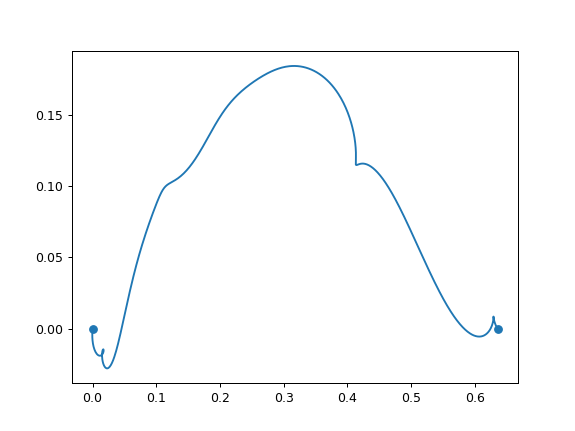

In [29]:
x_found = ans.y[0,:]
y_found = ans.y[1,:]

plt.figure()
plt.plot(x_found, y_found)
plt.scatter([q_init[0], q_d_fin[0]], [q_init[1], q_d_fin[1]])
plt.show()